In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
test_df = pd.read_csv("../Data/TestSet.csv")

In [36]:
test_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2737 entries, 0 to 2736
Data columns (total 446 columns):
 #    Column                                  Dtype  
---   ------                                  -----  
 0    Age                                     float64
 1    NumOfAccounts                           float64
 2    NumOfClosedAccounts                     float64
 3    NumOfCompletedOrders                    float64
 4    NumOfCanceledOrders                     float64
 5    TotalExecutedQuantity                   float64
 6    TotalQuantity                           float64
 7    AvgPrice                                float64
 8    OrderType_Buy                           float64
 9    OrderType_Sell                          float64
 10   SecurityID_0                            float64
 11   SecurityID_1                            float64
 12   SecurityID_2                            float64
 13   SecurityID_3                            float64
 14   SecurityID_4          

In [37]:
X_test = test_df.iloc[:, :-1].to_numpy()
y_test = test_df.iloc[:, -1].to_numpy()

In [38]:
with open("../RandomForestModel.pkl", "rb") as f:
    model = pickle.load(f)

In [39]:
predictions = model.predict(X_test)

In [48]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1387
           1       0.93      0.90      0.92      1350

    accuracy                           0.92      2737
   macro avg       0.92      0.92      0.92      2737
weighted avg       0.92      0.92      0.92      2737



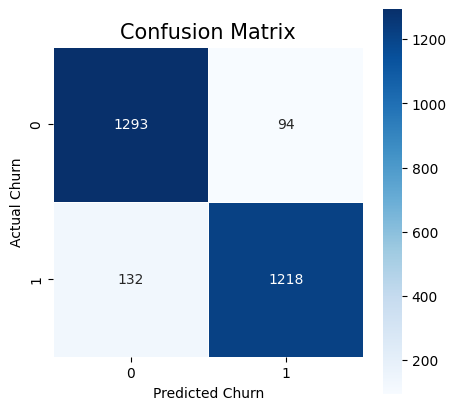

In [47]:
cm = confusion_matrix(y_test, predictions)

# Create a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues")
plt.ylabel("Actual Churn")
plt.xlabel("Predicted Churn")
plt.title("Confusion Matrix", size=15)
plt.show()

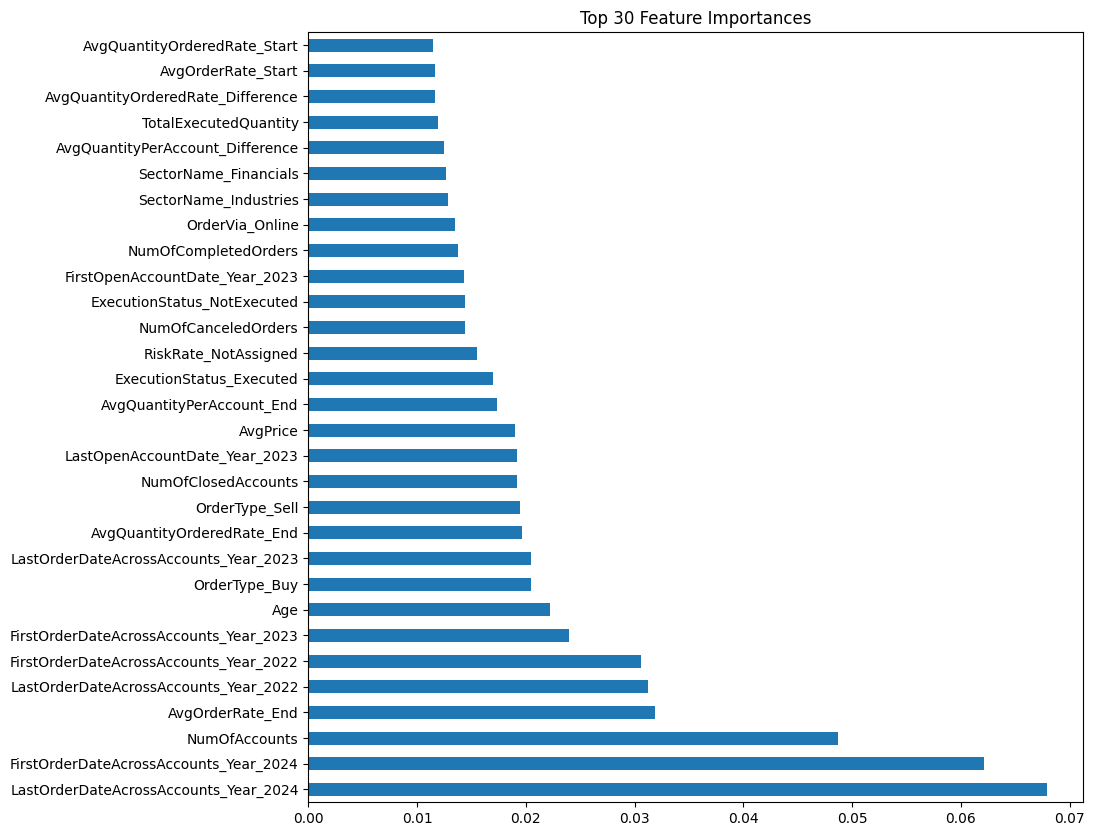

In [42]:
importances = model.feature_importances_
feature_importances = pd.Series(
    importances, index=test_df.columns[:-1]
)  # excluding the target variable
top_n = 30
top_n_importances = feature_importances.sort_values(ascending=False)[:top_n]

# Now plot the top N importances
plt.figure(figsize=(10, 10))
top_n_importances.plot(kind="barh")
plt.title("Top {} Feature Importances".format(top_n))
plt.show()

In [43]:
churn_rate = test_df["Churned"].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 49.32%


In [45]:
correlations = (
    test_df.loc[:, (test_df != test_df.iloc[0]).any()].corr()["Churned"].sort_values()
)
print("Most Positive Correlations:\n", correlations.tail(10))
print("\nMost Negative Correlations:\n", correlations.head(10))

Most Positive Correlations:
 FirstOpenAccountDate_Year_2001            0.038136
SecurityID_170                            0.038374
SecurityID_284                            0.043238
SecurityID_228                            0.047516
OrderVia_Email                            0.049172
NumOfClosedAccounts                       0.230485
NumOfAccounts                             0.235886
FirstOrderDateAcrossAccounts_Year_2022    0.452383
LastOrderDateAcrossAccounts_Year_2022     0.458824
Churned                                   1.000000
Name: Churned, dtype: float64

Most Negative Correlations:
 LastOrderDateAcrossAccounts_Year_2024    -0.571657
FirstOrderDateAcrossAccounts_Year_2024   -0.561689
AvgQuantityOrderedRate_End               -0.333257
NumOfCompletedOrders                     -0.323433
RiskRate_NotAssigned                     -0.322177
NumOfCanceledOrders                      -0.319687
LastOpenAccountDate_Year_2023            -0.311625
FirstOpenAccountDate_Year_2023           -0.

In [49]:
visualization_df = pd.read_csv("../Data/visualization_data.csv")

In [50]:
visualization_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8871 entries, 0 to 8870
Data columns (total 368 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    ClientID                              int64  
 1    Gender                                object 
 2    Age                                   int64  
 3    IsClientSuspended                     int64  
 4    RiskRate                              object 
 5    NumOfAccounts                         int64  
 6    NumOfClosedAccounts                   int64  
 7    NumOfSuspendedAccounts                int64  
 8    NumOfOrders                           int64  
 9    NumOfCompletedOrders                  int64  
 10   NumOfCanceledOrders                   int64  
 11   TotalExecutedQuantity                 int64  
 12   TotalQuantity                         int64  
 13   AvgPrice                              float64
 14   SecurityID_0                          float64
 15   Se

In [53]:
churned_men = len(
    visualization_df[
        (visualization_df["Gender"] == "Male") & visualization_df["Churned"] == 1
    ]
)
all_men = len(visualization_df[visualization_df["Gender"] == "Male"])

print("Percentage of women that churned: ", churned_men / all_men * 100)

Percentage of women that churned:  21.08369910700772


In [52]:
churned_women = len(
    visualization_df[
        (visualization_df["Gender"] == "Female") & visualization_df["Churned"] == 1
    ]
)
all_women = len(visualization_df[visualization_df["Gender"] == "Female"])

print("Percentage of women that churned: ", churned_women / all_women * 100)

Percentage of women that churned:  22.791519434628977


<Axes: xlabel='Churned', ylabel='AvgOrderRate_Difference'>

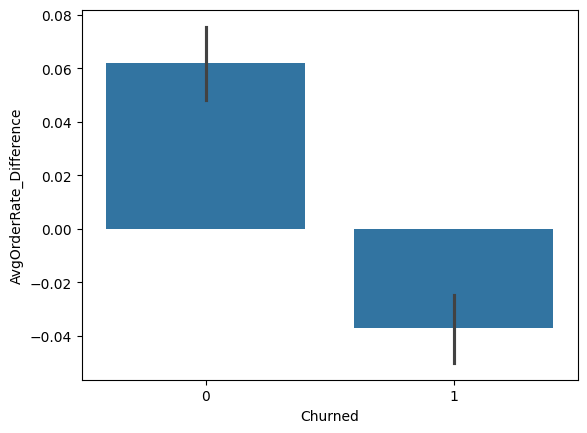

In [57]:
sns.barplot(visualization_df, x="Churned", y="AvgOrderRate_Difference")

<Axes: xlabel='Churned', ylabel='AvgQuantityOrderedRate_Difference'>

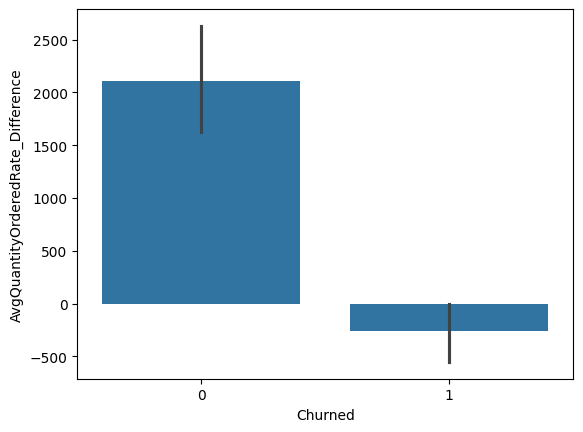

In [58]:
sns.barplot(visualization_df, x="Churned", y="AvgQuantityOrderedRate_Difference")

<Axes: xlabel='Churned', ylabel='AvgQuantityPerAccount_Difference'>

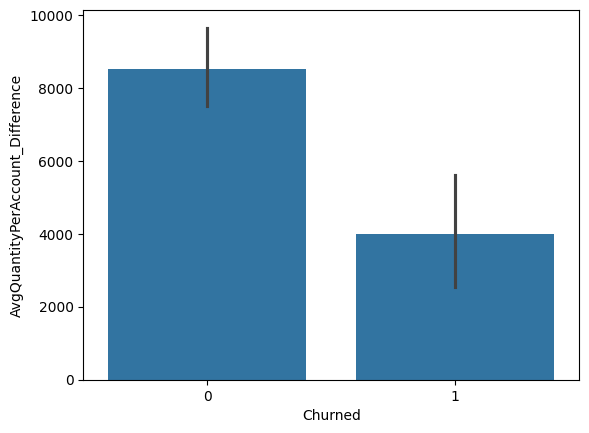

In [59]:
sns.barplot(visualization_df, x="Churned", y="AvgQuantityPerAccount_Difference")

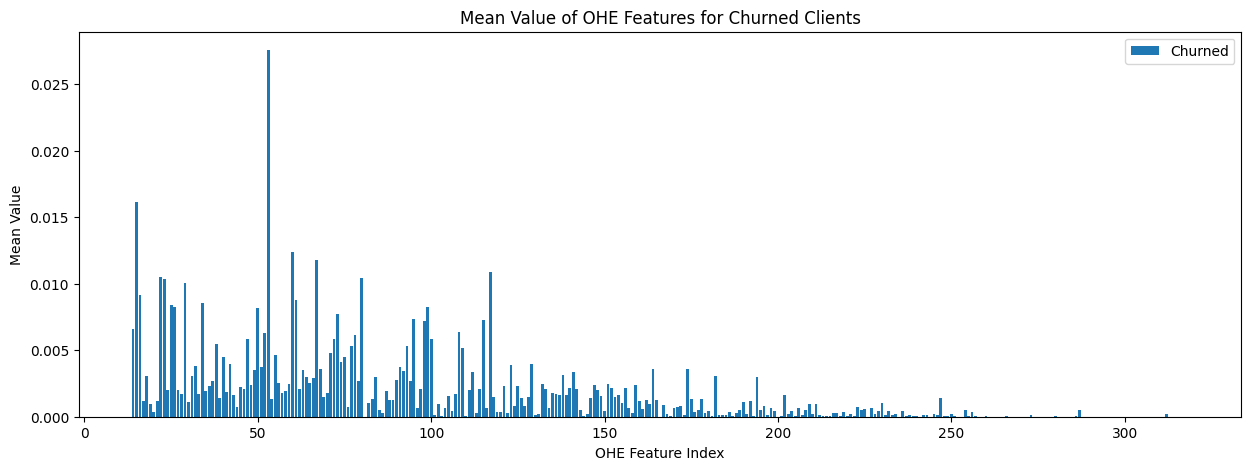

In [60]:
mean_values = (
    visualization_df[visualization_df["Churned"] == 1]
    .iloc[:, 14:319]
    .groupby(visualization_df["Churned"])
    .mean()
)


# Plotting
fig, ax = plt.subplots(figsize=(15, 5))


# Plot the mean values for the churned clients (binary_label == 1)
ax.bar(range(14, 319), mean_values.loc[1], label="Churned")


# Customize the plot
ax.set_xlabel("OHE Feature Index")
ax.set_ylabel("Mean Value")
ax.set_title("Mean Value of OHE Features for Churned Clients")
ax.legend()

In [61]:
def create_bins(df):
    quantiles = df.quantile([0, 0.1, 0.25, 0.5, 0.8, 1])
    bins_df = pd.cut(
        df, bins=quantiles, labels=["17-29", "28-37", "38-50", "51-65", "69-79"]
    )
    return bins_df

In [62]:
bins = create_bins(visualization_df["Age"])
visualization_df["Age"] = pd.Series(bins)

<Axes: xlabel='RiskRate', ylabel='count'>

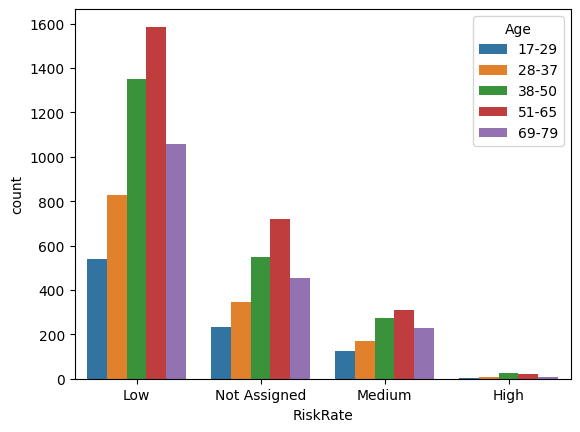

In [63]:
sns.countplot(x="RiskRate", data=visualization_df, hue="Age")

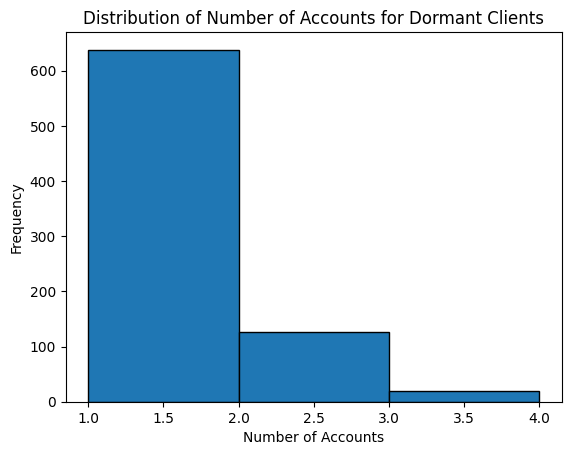

In [64]:
dormant_clients = visualization_df[visualization_df["IsDormant"] == 1]


# Plot the distribution of the number of accounts
plt.hist(
    dormant_clients["NumOfAccounts"],
    bins=range(1, dormant_clients["NumOfAccounts"].max() + 1),
    edgecolor="black",
)


# Customize the plot
plt.xlabel("Number of Accounts")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Accounts for Dormant Clients")


# Show the plot
plt.show()

<Axes: xlabel='Age', ylabel='NumOfOrders'>

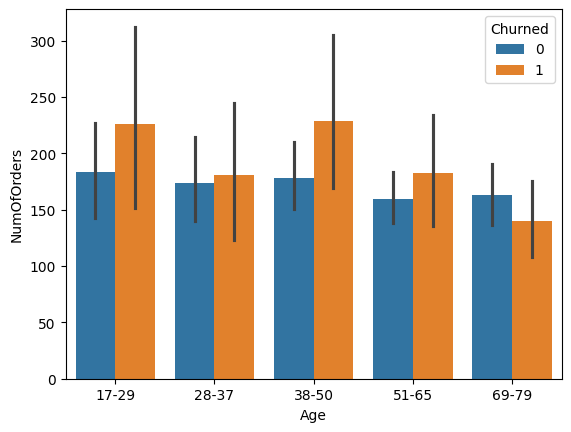

In [90]:
sns.barplot(x="Age", y="NumOfOrders", data=visualization_df, hue="Churned")

<Axes: xlabel='Age', ylabel='NumOfAccounts'>

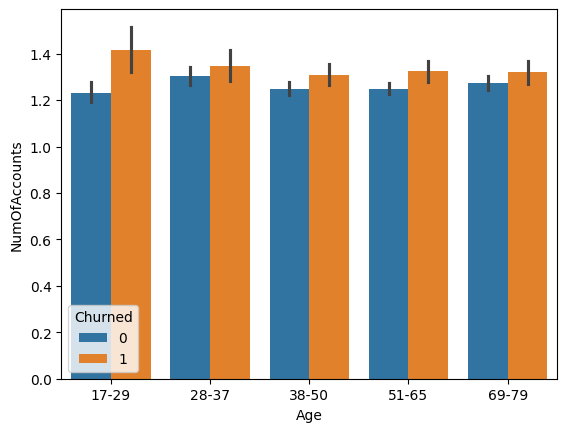

In [91]:
sns.barplot(x="Age", y="NumOfAccounts", data=visualization_df, hue="Churned")

<Axes: xlabel='Age', ylabel='AvgOrderRate_Difference'>

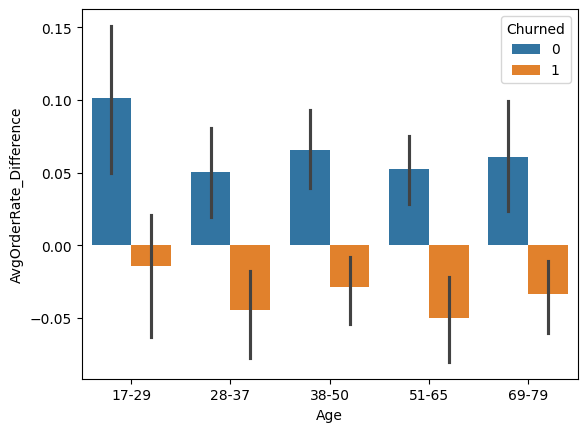

In [85]:
sns.barplot(x="Age", y="AvgOrderRate_Difference", data=visualization_df, hue="Churned")

<Axes: xlabel='Age', ylabel='AvgQuantityOrderedRate_Difference'>

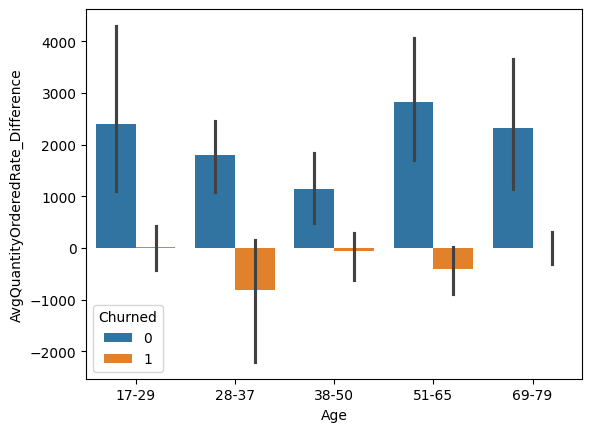

In [87]:
sns.barplot(
    x="Age",
    y="AvgQuantityOrderedRate_Difference",
    data=visualization_df,
    hue="Churned",
)

<Axes: xlabel='Age', ylabel='AvgQuantityPerAccount_Difference'>

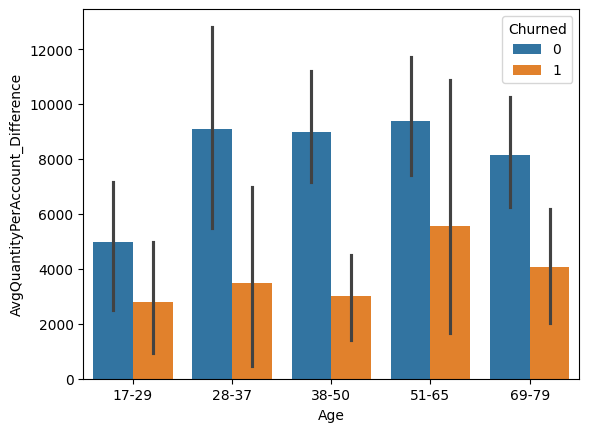

In [74]:
sns.barplot(
    x="Age", y="AvgQuantityPerAccount_Difference", data=visualization_df, hue="Churned"
)

<Axes: xlabel='Gender', ylabel='AvgOrderRate_Difference'>

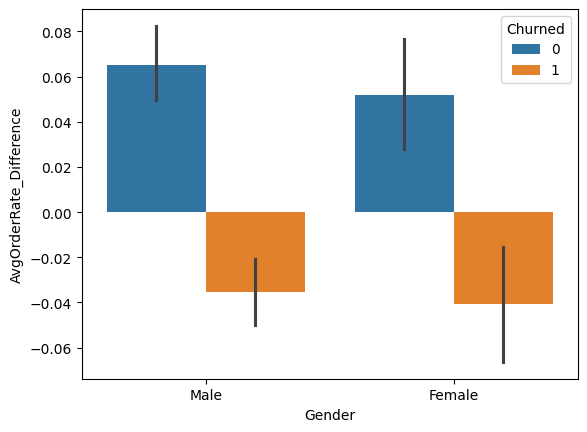

In [88]:
sns.barplot(
    x="Gender", y="AvgOrderRate_Difference", data=visualization_df, hue="Churned"
)

<Axes: xlabel='Gender', ylabel='AvgQuantityOrderedRate_Difference'>

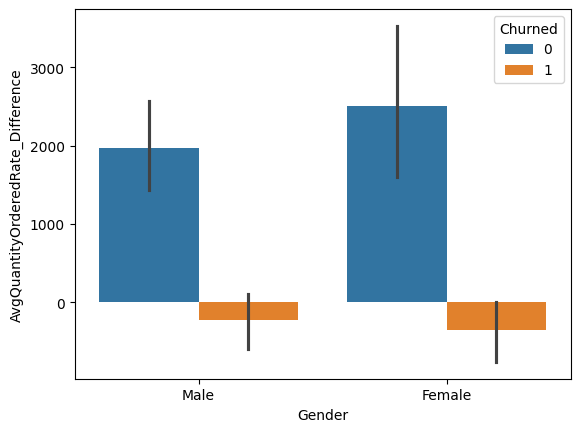

In [89]:
sns.barplot(
    x="Gender",
    y="AvgQuantityOrderedRate_Difference",
    data=visualization_df,
    hue="Churned",
)

<Axes: xlabel='Gender', ylabel='AvgQuantityPerAccount_Difference'>

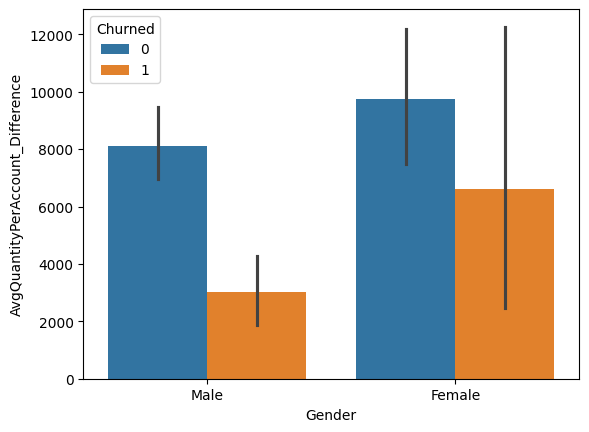

In [92]:
sns.barplot(
    x="Gender",
    y="AvgQuantityPerAccount_Difference",
    data=visualization_df,
    hue="Churned",
)

<Axes: xlabel='Age', ylabel='NumOfOrders'>

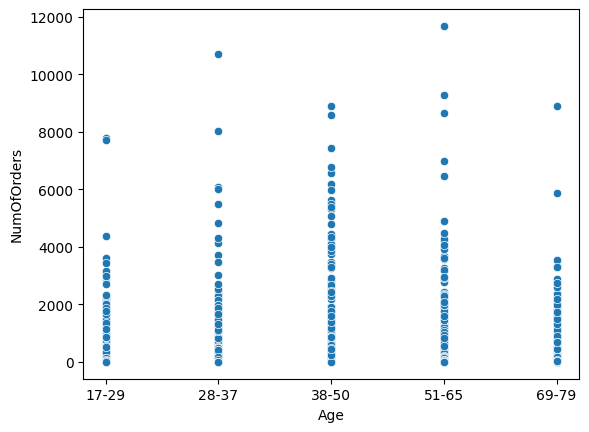

In [94]:
sns.scatterplot(x="Age", y="NumOfOrders", data=visualization_df)

<Axes: xlabel='NumOfSuspendedAccounts', ylabel='count'>

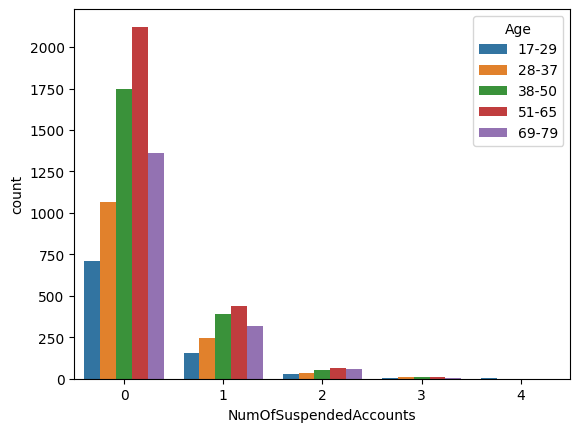

In [95]:
sns.countplot(x="NumOfSuspendedAccounts", data=visualization_df, hue="Age")

<Axes: xlabel='NumOfSuspendedAccounts', ylabel='count'>

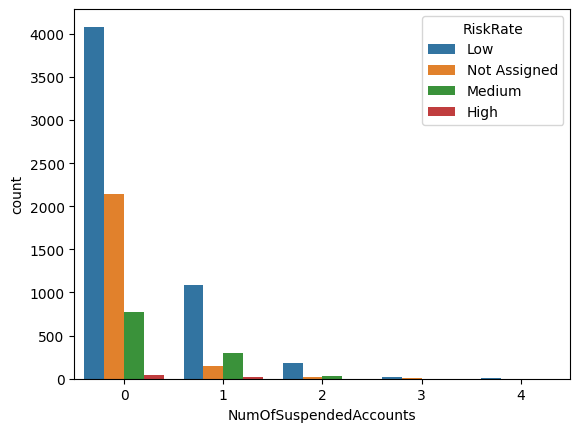

In [97]:
sns.countplot(x="NumOfSuspendedAccounts", data=visualization_df, hue="RiskRate")

<Axes: xlabel='Age', ylabel='count'>

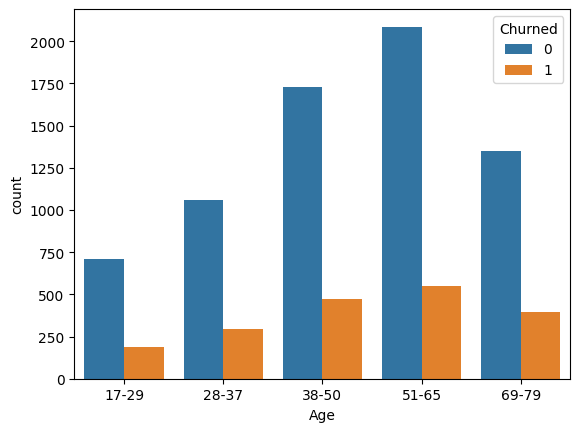

In [98]:
sns.countplot(x="Age", data=visualization_df, hue="Churned")

<Axes: xlabel='Gender', ylabel='count'>

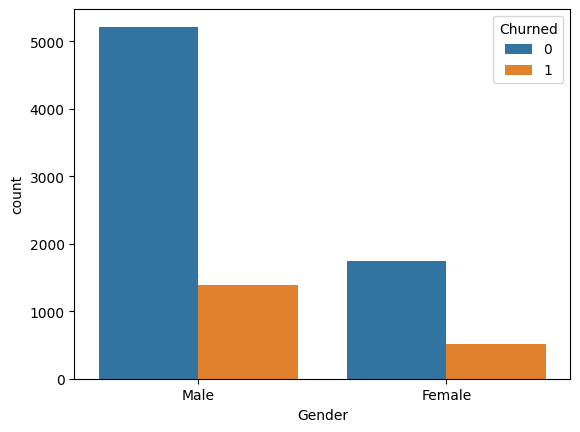

In [99]:
sns.countplot(x="Gender", data=visualization_df, hue="Churned")

<Axes: xlabel='NumOfAccounts', ylabel='count'>

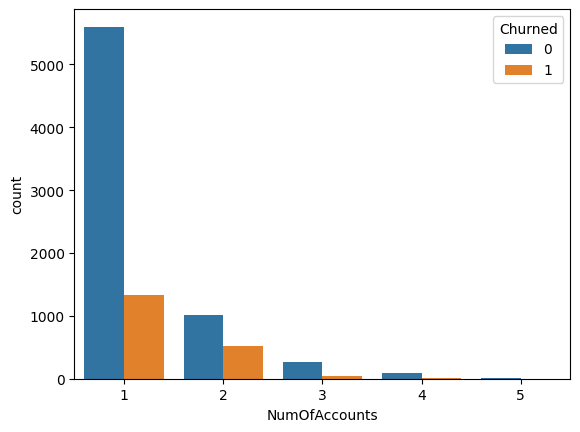

In [101]:
sns.countplot(x="NumOfAccounts", data=visualization_df, hue="Churned")

<Axes: xlabel='NumOfAccounts', ylabel='count'>

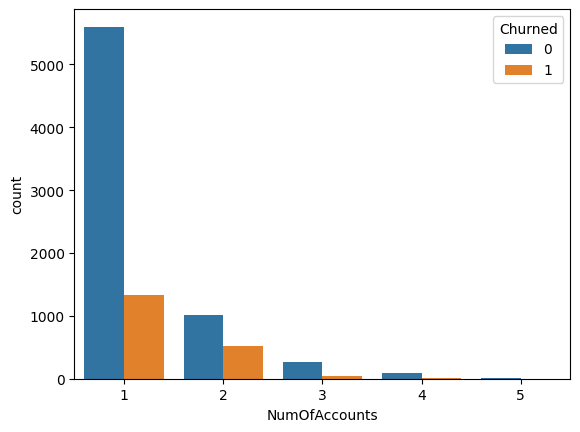

In [100]:
sns.countplot(x="NumOfAccounts", data=visualization_df, hue="Churned")